In [1]:
# load packages
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
# N, D = X_train.shape

In [2]:
HOME = '/home/m2021ksugawara/work/tick_research'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
#特徴量を板の基本情報（気配値から１０レベル以内のask,ask_vol,bid,bid_volの４つのグラフ）のみに絞る関数
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

#labelを取得（５つある理由は
def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape  #N=n,D=40
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]   #入力データとして直近100の状態を使うので、ラベルデータの最初のT-1(=99)個は不要。具体的にはevent time100における予測を行うには1~100の時刻の状態を入力として時刻100のラベルを使うから

    dataX = np.zeros((N - T + 1, T, D))  #(サンプル数,直近100時刻前までの状態=100,特徴量次元=40)
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY   #dataX.shape=(サンプル数=N-100,直近の状態=100,各時刻の特徴量次元=40),dataY.shape=(サンプル数=N-100,ラベル次元=5)

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [5]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)  #特徴量の取得：(n,40)
        y = get_label(data)  #ラベルの取得：(n,5)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1  #4step先の仲値の平均値を使用して算出したラベル値を採用することを意味している。-1しているのは0,1,2にしている。（なぜ？）
        self.length = len(x)
#         print(f'{y.shape} in dataset')
#         print(y)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]


# Data Preparation
dataの特徴：
training dataのファイル名の数字はi番目のデータセット(fold)であることを意味してるが、これは1日目〜i日目までのデータが含まれていることを意味している。一方でtest dataの場合、数字iが含まれているファイルはi+1日目のデータが含まれていることを意味している。
<span style="color: red; ">
    ここは注意。test dataは一日目のデータがないのでファイル名に1が入っているファイルの中身は2日目のデータ。
</span>
DeepLOBの論文では以下の２つのSetUpで実験している。<br>
①：1日目〜i日目までのデータをトレーニングデータとして使い、i+1日目までのデータをテストデータとして使う。これをi=1~9で試す(交差検証)
<br>
➁：1日目〜7日目までのデータをトレーニングデータとして使い、8〜10日目までのデータをテストデータとして使う。
<br>
以下では➁のパターンの再現をしている

In [6]:
# please change the data_path to your local path
# data_path = '/nfs/home/zihaoz/limit_order_book/data'
data_path = f'{HOME}/published/BenchmarkDatasets/BenchmarkDatasets'

dec_data = np.loadtxt(f'{data_path}/Auction/1.Auction_Zscore/Auction_Zscore_Training/Train_Dst_Auction_ZScore_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt(f'{data_path}/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt(f'{data_path}/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt(f'{data_path}/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))
print(dec_test1.shape)

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 59973)
(149, 242360) (149, 60591) (149, 155174)


In [7]:
batch_size = 64
#下のT=100は入力のxとして直近100の状態を使うということを意味している。
#k=4はlabelを作成するときに現在時刻からk(=4)step先の状態までの仲値の平均としきい値を比較して上昇、下降、変化なしを決定している値を撮ってきていることを意味している。
#つまりこのモデルは過去T=100step前までのデータを用いてk=4step先にかけての変動を予測するものになるということ？4step先で意味あるのか？
#num_classes=3は「上昇」「下降」「変化なし」の３つのクラスでラベリングしていることを表している。
dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

torch.Size([242261, 1, 100, 40]) torch.Size([242261])


In [8]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[-1.0257,  0.8198, -1.0251,  ..., -0.3117, -1.0240, -0.3237],
          [-1.0257,  1.9649, -1.0261,  ..., -0.3117, -1.0250,  1.8370],
          [-1.0257,  1.9649, -1.0251,  ..., -0.3117, -1.0240, -0.3237],
          ...,
          [-1.0247, -0.6698, -1.0251,  ..., -0.3117, -1.0240, -0.3237],
          [-1.0247, -0.6698, -1.0251,  ..., -0.3117, -1.0240, -0.3237],
          [-1.0247,  0.5497, -1.0251,  ..., -0.3117, -1.0240, -0.3237]]]],
       dtype=torch.float64)
tensor([0.], dtype=torch.float64)
torch.Size([1, 1, 100, 40]) torch.Size([1])


# Model Architecture

In [9]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [10]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(device)

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [11]:
summary(model, (1, 1, 100, 40))

/home/m2021ksugawara/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
deeplob                                  --                        --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [13]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            torch.save(model, './best_val_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [14]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=50)

  2%|▊                                        | 1/50 [07:21<6:00:47, 441.79s/it]

model saved
Epoch 1/50, Train Loss: 0.9103,           Validation Loss: 0.9444, Duration: 0:07:21.787293, Best Val Epoch: 0


  4%|█▋                                       | 2/50 [14:44<5:54:01, 442.53s/it]

model saved
Epoch 2/50, Train Loss: 0.8226,           Validation Loss: 0.9312, Duration: 0:07:23.052329, Best Val Epoch: 1


  6%|██▍                                      | 3/50 [22:07<5:46:36, 442.49s/it]

model saved
Epoch 3/50, Train Loss: 0.7959,           Validation Loss: 0.9103, Duration: 0:07:22.433505, Best Val Epoch: 2


  8%|███▎                                     | 4/50 [29:29<5:39:07, 442.33s/it]

model saved
Epoch 4/50, Train Loss: 0.7771,           Validation Loss: 0.9089, Duration: 0:07:22.086881, Best Val Epoch: 3


 10%|████                                     | 5/50 [36:51<5:31:44, 442.33s/it]

model saved
Epoch 5/50, Train Loss: 0.7626,           Validation Loss: 0.8974, Duration: 0:07:22.317686, Best Val Epoch: 4


 12%|████▉                                    | 6/50 [44:14<5:24:22, 442.33s/it]

model saved
Epoch 6/50, Train Loss: 0.7523,           Validation Loss: 0.8844, Duration: 0:07:22.349429, Best Val Epoch: 5


 14%|█████▋                                   | 7/50 [51:36<5:17:03, 442.40s/it]

Epoch 7/50, Train Loss: 0.7435,           Validation Loss: 0.8998, Duration: 0:07:22.522116, Best Val Epoch: 5


 16%|██████▌                                  | 8/50 [58:58<5:09:41, 442.41s/it]

Epoch 8/50, Train Loss: 0.7353,           Validation Loss: 0.8891, Duration: 0:07:22.429166, Best Val Epoch: 5


 18%|███████                                | 9/50 [1:06:21<5:02:20, 442.44s/it]

Epoch 9/50, Train Loss: 0.7290,           Validation Loss: 0.8884, Duration: 0:07:22.515504, Best Val Epoch: 5


 20%|███████▌                              | 10/50 [1:13:43<4:54:56, 442.42s/it]

Epoch 10/50, Train Loss: 0.7228,           Validation Loss: 0.8904, Duration: 0:07:22.368417, Best Val Epoch: 5


 22%|████████▎                             | 11/50 [1:21:06<4:47:31, 442.35s/it]

model saved
Epoch 11/50, Train Loss: 0.7188,           Validation Loss: 0.8784, Duration: 0:07:22.200802, Best Val Epoch: 10


 24%|█████████                             | 12/50 [1:28:28<4:40:12, 442.43s/it]

Epoch 12/50, Train Loss: 0.7133,           Validation Loss: 0.8914, Duration: 0:07:22.617987, Best Val Epoch: 10


 26%|█████████▉                            | 13/50 [1:35:51<4:32:50, 442.44s/it]

Epoch 13/50, Train Loss: 0.7093,           Validation Loss: 0.8847, Duration: 0:07:22.456982, Best Val Epoch: 10


 28%|██████████▋                           | 14/50 [1:43:13<4:25:28, 442.46s/it]

Epoch 14/50, Train Loss: 0.7053,           Validation Loss: 0.8819, Duration: 0:07:22.498729, Best Val Epoch: 10


 30%|███████████▍                          | 15/50 [1:50:36<4:18:07, 442.51s/it]

Epoch 15/50, Train Loss: 0.7016,           Validation Loss: 0.8811, Duration: 0:07:22.623094, Best Val Epoch: 10


 32%|████████████▏                         | 16/50 [1:57:59<4:10:52, 442.71s/it]

Epoch 16/50, Train Loss: 0.6985,           Validation Loss: 0.8819, Duration: 0:07:23.177467, Best Val Epoch: 10


 34%|████████████▉                         | 17/50 [2:05:22<4:03:35, 442.91s/it]

Epoch 17/50, Train Loss: 0.6952,           Validation Loss: 0.8981, Duration: 0:07:23.366553, Best Val Epoch: 10


 36%|█████████████▋                        | 18/50 [2:12:46<3:56:21, 443.17s/it]

Epoch 18/50, Train Loss: 0.6915,           Validation Loss: 0.8915, Duration: 0:07:23.772302, Best Val Epoch: 10


 38%|██████████████▍                       | 19/50 [2:20:10<3:49:05, 443.42s/it]

Epoch 19/50, Train Loss: 0.6897,           Validation Loss: 0.8879, Duration: 0:07:23.997120, Best Val Epoch: 10


 40%|███████████████▏                      | 20/50 [2:27:34<3:41:48, 443.61s/it]

Epoch 20/50, Train Loss: 0.6870,           Validation Loss: 0.8878, Duration: 0:07:24.048454, Best Val Epoch: 10


 42%|███████████████▉                      | 21/50 [2:34:58<3:34:31, 443.83s/it]

Epoch 21/50, Train Loss: 0.6850,           Validation Loss: 0.8945, Duration: 0:07:24.348757, Best Val Epoch: 10


 44%|████████████████▋                     | 22/50 [2:42:23<3:27:10, 443.93s/it]

Epoch 22/50, Train Loss: 0.6820,           Validation Loss: 0.8912, Duration: 0:07:24.163382, Best Val Epoch: 10


 46%|█████████████████▍                    | 23/50 [2:49:47<3:19:51, 444.13s/it]

Epoch 23/50, Train Loss: 0.6801,           Validation Loss: 0.8924, Duration: 0:07:24.606543, Best Val Epoch: 10


 48%|██████████████████▏                   | 24/50 [2:57:12<3:12:31, 444.28s/it]

Epoch 24/50, Train Loss: 0.6782,           Validation Loss: 0.8918, Duration: 0:07:24.606396, Best Val Epoch: 10


 50%|███████████████████                   | 25/50 [3:04:37<3:05:11, 444.46s/it]

Epoch 25/50, Train Loss: 0.6770,           Validation Loss: 0.9012, Duration: 0:07:24.882089, Best Val Epoch: 10


 52%|███████████████████▊                  | 26/50 [3:12:01<2:57:48, 444.51s/it]

Epoch 26/50, Train Loss: 0.6743,           Validation Loss: 0.8909, Duration: 0:07:24.616160, Best Val Epoch: 10


 54%|████████████████████▌                 | 27/50 [3:19:26<2:50:25, 444.58s/it]

Epoch 27/50, Train Loss: 0.6730,           Validation Loss: 0.8882, Duration: 0:07:24.760291, Best Val Epoch: 10


 56%|█████████████████████▎                | 28/50 [3:26:51<2:43:02, 444.68s/it]

Epoch 28/50, Train Loss: 0.6716,           Validation Loss: 0.8975, Duration: 0:07:24.901926, Best Val Epoch: 10


 58%|██████████████████████                | 29/50 [3:34:16<2:35:39, 444.76s/it]

Epoch 29/50, Train Loss: 0.6700,           Validation Loss: 0.8963, Duration: 0:07:24.934993, Best Val Epoch: 10


 60%|██████████████████████▊               | 30/50 [3:41:41<2:28:16, 444.85s/it]

Epoch 30/50, Train Loss: 0.6684,           Validation Loss: 0.8882, Duration: 0:07:25.063099, Best Val Epoch: 10


 62%|███████████████████████▌              | 31/50 [3:49:06<2:20:54, 444.95s/it]

Epoch 31/50, Train Loss: 0.6669,           Validation Loss: 0.8912, Duration: 0:07:25.196939, Best Val Epoch: 10


 64%|████████████████████████▎             | 32/50 [3:56:31<2:13:30, 445.01s/it]

Epoch 32/50, Train Loss: 0.6661,           Validation Loss: 0.8946, Duration: 0:07:25.126458, Best Val Epoch: 10


 66%|█████████████████████████             | 33/50 [4:03:56<2:06:04, 444.99s/it]

Epoch 33/50, Train Loss: 0.6649,           Validation Loss: 0.8994, Duration: 0:07:24.945240, Best Val Epoch: 10


 68%|█████████████████████████▊            | 34/50 [4:11:21<1:58:40, 445.04s/it]

Epoch 34/50, Train Loss: 0.6638,           Validation Loss: 0.8917, Duration: 0:07:25.169608, Best Val Epoch: 10


 70%|██████████████████████████▌           | 35/50 [4:18:47<1:51:15, 445.05s/it]

Epoch 35/50, Train Loss: 0.6631,           Validation Loss: 0.8967, Duration: 0:07:25.062602, Best Val Epoch: 10


 72%|███████████████████████████▎          | 36/50 [4:26:12<1:43:51, 445.07s/it]

Epoch 36/50, Train Loss: 0.6615,           Validation Loss: 0.8948, Duration: 0:07:25.125958, Best Val Epoch: 10


 74%|████████████████████████████          | 37/50 [4:33:37<1:36:28, 445.25s/it]

Epoch 37/50, Train Loss: 0.6608,           Validation Loss: 0.8955, Duration: 0:07:25.650753, Best Val Epoch: 10


 76%|████████████████████████████▉         | 38/50 [4:41:03<1:29:04, 445.38s/it]

Epoch 38/50, Train Loss: 0.6597,           Validation Loss: 0.8989, Duration: 0:07:25.684150, Best Val Epoch: 10


 78%|█████████████████████████████▋        | 39/50 [4:48:28<1:21:39, 445.38s/it]

Epoch 39/50, Train Loss: 0.6594,           Validation Loss: 0.8934, Duration: 0:07:25.399221, Best Val Epoch: 10


 80%|██████████████████████████████▍       | 40/50 [4:55:54<1:14:14, 445.48s/it]

Epoch 40/50, Train Loss: 0.6581,           Validation Loss: 0.8927, Duration: 0:07:25.706521, Best Val Epoch: 10


 82%|███████████████████████████████▏      | 41/50 [5:03:20<1:06:49, 445.47s/it]

Epoch 41/50, Train Loss: 0.6574,           Validation Loss: 0.8942, Duration: 0:07:25.449537, Best Val Epoch: 10


 84%|█████████████████████████████████▌      | 42/50 [5:10:45<59:23, 445.49s/it]

Epoch 42/50, Train Loss: 0.6570,           Validation Loss: 0.8898, Duration: 0:07:25.528631, Best Val Epoch: 10


 86%|██████████████████████████████████▍     | 43/50 [5:18:11<51:58, 445.53s/it]

Epoch 43/50, Train Loss: 0.6562,           Validation Loss: 0.8912, Duration: 0:07:25.618892, Best Val Epoch: 10


 88%|███████████████████████████████████▏    | 44/50 [5:25:37<44:33, 445.62s/it]

Epoch 44/50, Train Loss: 0.6548,           Validation Loss: 0.8968, Duration: 0:07:25.841174, Best Val Epoch: 10


 90%|████████████████████████████████████    | 45/50 [5:33:02<37:08, 445.70s/it]

Epoch 45/50, Train Loss: 0.6538,           Validation Loss: 0.9001, Duration: 0:07:25.877978, Best Val Epoch: 10


 92%|████████████████████████████████████▊   | 46/50 [5:40:28<29:43, 445.81s/it]

Epoch 46/50, Train Loss: 0.6537,           Validation Loss: 0.8973, Duration: 0:07:26.060604, Best Val Epoch: 10


 94%|█████████████████████████████████████▌  | 47/50 [5:47:55<22:17, 445.98s/it]

Epoch 47/50, Train Loss: 0.6525,           Validation Loss: 0.9041, Duration: 0:07:26.366218, Best Val Epoch: 10


 96%|██████████████████████████████████████▍ | 48/50 [5:55:21<14:52, 446.02s/it]

Epoch 48/50, Train Loss: 0.6517,           Validation Loss: 0.8956, Duration: 0:07:26.109937, Best Val Epoch: 10


 98%|███████████████████████████████████████▏| 49/50 [6:02:47<07:26, 446.07s/it]

Epoch 49/50, Train Loss: 0.6516,           Validation Loss: 0.8965, Duration: 0:07:26.192040, Best Val Epoch: 10


100%|████████████████████████████████████████| 50/50 [6:10:13<00:00, 444.27s/it]

Epoch 50/50, Train Loss: 0.6507,           Validation Loss: 0.8954, Duration: 0:07:26.000495, Best Val Epoch: 10


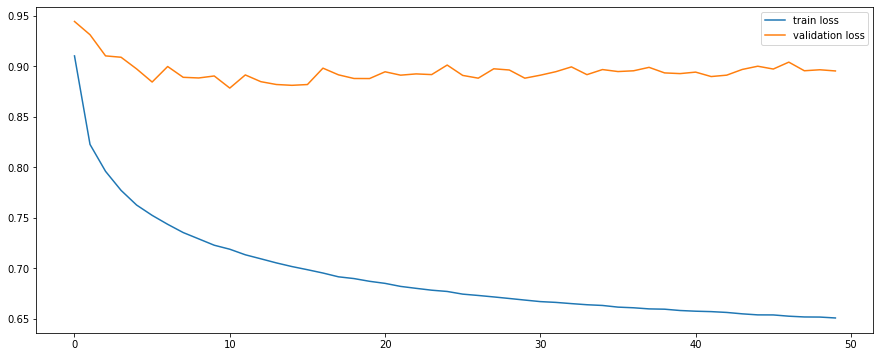

In [15]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

# Model Testing

In [16]:
model = torch.load('best_val_model_pytorch')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")


Test acc: 0.7532


In [17]:
# model = torch.load('best_val_model_pytorch')
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)

In [18]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.7531903917459294
              precision    recall  f1-score   support

           0     0.7210    0.7450    0.7328     53181
           1     0.8130    0.8045    0.8087     52523
           2     0.7254    0.7074    0.7163     49371

    accuracy                         0.7532    155075
   macro avg     0.7531    0.7523    0.7526    155075
weighted avg     0.7536    0.7532    0.7533    155075

